In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from ydata_profiling import ProfileReport # ehemals pandas profiling report

# scikit learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix  #, accuracy_score  
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay

import xgboost as xgb

In [2]:
# csv-Datensatz als DataFrame einlesen und ausgeben
df = pd.read_csv('ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
df.shape

(10000, 14)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


In [5]:
# boolean mask for categorical columns
categorical_mask = df.dtypes == object

# list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()
print(df[categorical_columns].head())

#Hinweis: Code basierend auf Übung "Encoding categorical columns I: LabelEncoder" in DataCamp. URL: https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/using-xgboost-in-pipelines?ex=3

  Product ID Type
0     M14860    M
1     L47181    L
2     L47182    L
3     L47183    L
4     L47184    L


Der Profiling Report wurde als html-Datei beigefügt

In [6]:
# Profiling Report
# profile = ProfileReport(df, title="Profiling Report")
# profile

In [7]:
# Bericht als HTML-Datei speichern
# profile.to_file("predictive_maintenance_profiling_report.html")

In [8]:
# Untersuchung erster TWF
df[df['TWF'] == 1].iloc[0]

UDI                            78
Product ID                 L47257
Type                            L
Air temperature [K]         298.8
Process temperature [K]     308.9
Rotational speed [rpm]       1455
Torque [Nm]                  41.3
Tool wear [min]               208
Machine failure                 1
TWF                             1
HDF                             0
PWF                             0
OSF                             0
RNF                             0
Name: 77, dtype: object

In [9]:
# UDI als Index setzen
df.set_index('UDI', inplace = True)
df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [10]:
# Untersuchung um ersten TWF herum
df.loc[75:82, ['Product ID', 'Type', 'Tool wear [min]', 'Machine failure', 'TWF']]

,Product ID,Type,Tool wear [min],Machine failure,TWF
UDI,,,,,
75,L47254,L,202,0,0
76,L47255,L,204,0,0
77,L47256,L,206,0,0
78,L47257,L,208,1,1
79,L47258,L,0,0,0
80,L47259,L,2,0,0
81,H29494,H,4,0,0
82,L47261,L,9,0,0


In [11]:
# Missing Values
df_nan = pd.DataFrame()
df_nan['count'] = df.count()
df_nan['missing#'] = df.isna().sum()
df_nan['missing%'] = (((df.isna().sum())/len(df))*100).round(2)
df_nan['uniques'] = df.nunique().values
df_nan

,count,missing#,missing%,uniques
Product ID,10000,0,0.0,10000
Type,10000,0,0.0,3
Air temperature [K],10000,0,0.0,93
Process temperature [K],10000,0,0.0,82
Rotational speed [rpm],10000,0,0.0,941
Torque [Nm],10000,0,0.0,577
Tool wear [min],10000,0,0.0,246
Machine failure,10000,0,0.0,2
TWF,10000,0,0.0,2
HDF,10000,0,0.0,2


In [12]:
# nicht benötigte Attribute löschen
df.drop(columns=['Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
UDI,,,,,,,
1,M,298.1,308.6,1551,42.8,0,0
2,L,298.2,308.7,1408,46.3,3,0
3,L,298.1,308.5,1498,49.4,5,0
4,L,298.2,308.6,1433,39.5,7,0
5,L,298.2,308.7,1408,40.0,9,0


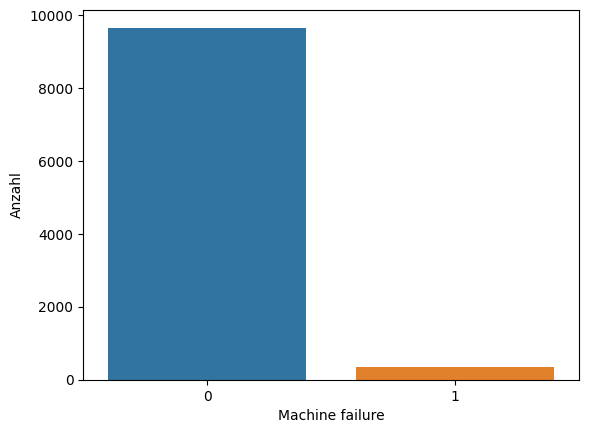

In [13]:
# Plot der Anzahl der Klassen
sns.countplot(x='Machine failure', data=df)

# Beschriftungen
plt.xlabel('Machine failure')
plt.ylabel('Anzahl')
plt.show()

In [14]:
# Anzahl für Klassen
mf_count = df['Machine failure'].value_counts()
print(mf_count)

0    9661
1     339
Name: Machine failure, dtype: int64


In [15]:
# %-Anteil für Klassen
df['Machine failure'].value_counts() / len(df)


0    0.9661
1    0.0339
Name: Machine failure, dtype: float64

In [16]:
# kategorische Variablen in numerische Variablen (dummy-Variablen) überführen
df = pd.get_dummies(df, columns=['Type'],drop_first=True)
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_L,Type_M
UDI,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,1
2,298.2,308.7,1408,46.3,3,0,1,0
3,298.1,308.5,1498,49.4,5,0,1,0
4,298.2,308.6,1433,39.5,7,0,1,0
5,298.2,308.7,1408,40.0,9,0,1,0


Die Namen der Attribute dürfen die Zeichen "[", ",", "]" oder "<" nicht enthalten, da sonst die folgende Fehlermeldung erscheint: "ValueError: feature_names must be string, and may not contain [, ] or <"

In [17]:
#Umbenennung der Attribute für Verarbeitung
df.rename(columns={'Air temperature [K]': 'Air temperature (K)', 'Process temperature [K]': 'Process temperature (K)', 'Rotational speed [rpm]': 'Rotational speed (rpm)', 'Torque [Nm]': 'Torque (Nm)', 'Tool wear [min]': 'Tool wear (min)'}, inplace=True)
df.head()

,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Machine failure,Type_L,Type_M
UDI,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,1
2,298.2,308.7,1408,46.3,3,0,1,0
3,298.1,308.5,1498,49.4,5,0,1,0
4,298.2,308.6,1433,39.5,7,0,1,0
5,298.2,308.7,1408,40.0,9,0,1,0


In [18]:
# neues Feature Temperaturunterschied erstellen
df['temp.difference (K)'] = df['Process temperature (K)'] - df['Air temperature (K)']
df.head()

,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Machine failure,Type_L,Type_M,temp.difference (K)
UDI,,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,1,10.5
2,298.2,308.7,1408,46.3,3,0,1,0,10.5
3,298.1,308.5,1498,49.4,5,0,1,0,10.4
4,298.2,308.6,1433,39.5,7,0,1,0,10.4
5,298.2,308.7,1408,40.0,9,0,1,0,10.5


# Model Trainieren

In [19]:
X = df.drop('Machine failure', axis=1)  
y = df['Machine failure']

In [20]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [21]:
# Überpfrüfung Aufteilung der Klassen in Trainings- und Testdatensatz 
value_count_train = y_train.value_counts()
value_count_test = y_test.value_counts()

print(f"Trainingsdatensatz:\n {value_count_train}\n\nTestdatensatz:\n {value_count_test}")

Trainingsdatensatz:
 0    7737
1     263
Name: Machine failure, dtype: int64

Testdatensatz:
 0    1924
1      76
Name: Machine failure, dtype: int64


In [22]:
# Berechnung XGBoost Hyperparameter für unbalanced classes
scale_pos_weight = value_count_train[0] / value_count_train[1]
scale_pos_weight

29.418250950570343

In [23]:
# Hyperparameter-Tuning mit GridSearchCV
param_grid = {
    'learning_rate': [0.5, 0.1, 0.01, 0.001], # eta, Step size shrinkage
    'n_estimators': [100, 200, 400], #number of boosting rounds, trees to build
    'max_depth': [1, 3, 5, 7], # Maximum depth of a tree
    'colsample_bytree': [0.5, 0.8, 1], # specifies the fraction of features to choose from at every split in a given tree. 
    "subsample": [0.5, 0.9, 1]} # dictates the fraction of the training data that is used during any given boosting round.

In [24]:
# XGBoost-Modell erstellen (instantiate model)
model = xgb.XGBClassifier(booster='gbtree', # tree based model
                        objective='reg:logistic',  # classification problems with decisions
                        n_jobs=-1, # assists with parallel execution
                        random_state=123,
                        scale_pos_weight=scale_pos_weight) # Controll the balance for unbalanced classes

In [25]:
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='recall', # a scoring function used to evaluate the model's performance
                           verbose=1, 
                           n_jobs=4) # assists with parallel execution
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=N...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     objective='reg:logistic', ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.5, 0.8, 1],
                         'learning_rate': [0.5, 0.1, 0.01, 0.001],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [100, 200, 400],
                         'subsample': [0.5, 0.9, 1]},
             scoring='recall', verbose=1)

In [26]:
# Grid Search Reslts for further information
# cv_results_df = pd.DataFrame(grid_search.cv_results_)
# cv_results_df

In [27]:
# Beste(n) Hyperarameter / Score 
print(f'Beste Hyperparameterkombination: {grid_search.best_params_}')
print(f"Best {grid_search.scoring}: {round(grid_search.best_score_, 3)}")

Beste Hyperparameterkombination: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
Best recall: 0.951


In [28]:
# Modell mit den besten Parametern trainieren
best_model = grid_search.best_estimator_ # GridSearchCV stores an estimator built with the best hyperparameters in the best_estimator property
best_model.fit(X_train, y_train) # Since it is an estimator, you can use this to predict on test set

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='reg:logistic', ...)

In [29]:
# Vorhersagen für Testdaten mit optimiertem Modell
y_pred = best_model.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1924
           1       0.25      0.89      0.39        76

    accuracy                           0.89      2000
   macro avg       0.62      0.89      0.67      2000
weighted avg       0.97      0.89      0.92      2000



In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1721  203]
 [   8   68]]


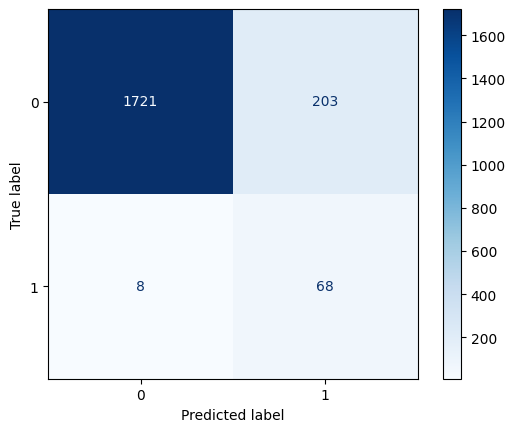

In [31]:
# Confusion Matrix Display
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.show()

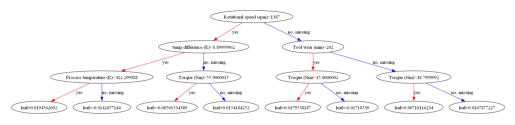

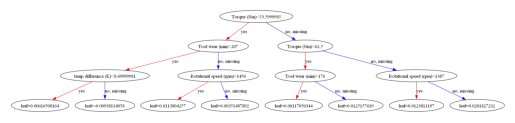

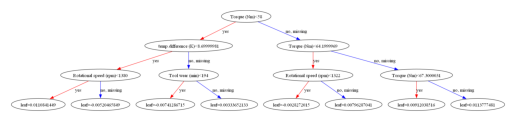

In [32]:
# plotting trees
xgb.plot_tree(best_model, num_trees=0)
plt.show()

xgb.plot_tree(best_model, num_trees=99) #, rankdir='LR'
plt.show()

xgb.plot_tree(best_model, num_trees=199)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

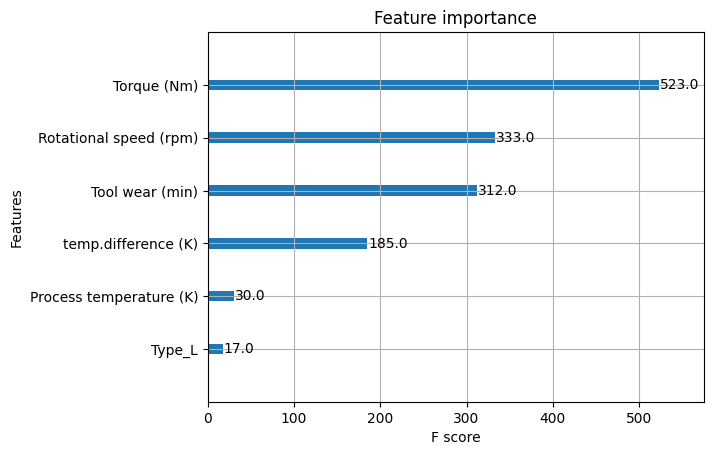

In [33]:
# feature importance
xgb.plot_importance(best_model)

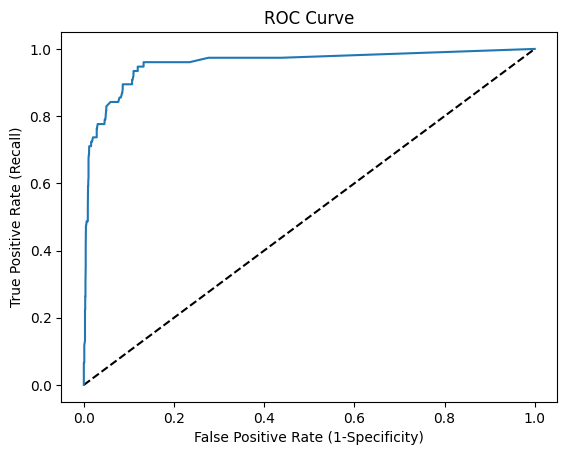

In [34]:
# ROC-Curve
# predicted probabilities
y_pred_prob = best_model.predict_proba(X_test)[:,1]

# ROC curve values
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)

#plot ROC curve
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.show()

#Hinweis: Code basierend auf Übung "Plotting an ROC curve" in DataCamp. URL: https://campus.datacamp.com/courses/machine-learning-with-scikit-learn-archived/fine-tuning-your-model?ex=5

In [35]:
# Schätzungen Ausfallwahrscheinlichkeit
# 'predict_proba' gibt eine Matrix zurück, wobei die erste Spalte die Wahrscheinlichkeit für Klasse 0 (kein Ausfall) und die zweite Spalte die Wahrscheinlichkeit für Klasse 1 (Ausfall) ist
print(f'Ausfallwahrscheinlichkeiten Testdatensatz:\n {best_model.predict_proba(X_test)[:,1]}')

Ausfallwahrscheinlichkeiten Testdatensatz:
 [0.26297843 0.11410547 0.11410547 ... 0.11410547 0.12323902 0.14294247]


In [36]:
# AUC score
print(f"AUC: {round(roc_auc_score(y_test, y_pred_prob),4)}")

# cross-validated AUC scores
cv_auc = cross_val_score(best_model, X, y, cv=5, scoring="roc_auc")

# list of AUC scores and mean
print(f"AUC Werte 5-fold CV: {cv_auc}")
print(f"mean AUC: {round(np.mean(cv_auc), 4)}")

#Hinweis: Code basierend auf Übung "AUC computation" in DataCamp. URL: https://campus.datacamp.com/courses/machine-learning-with-scikit-learn-archived/fine-tuning-your-model?ex=8

AUC: 0.9573
AUC Werte 5-fold CV: [0.93157338 0.95265878 0.95891944 0.94537435 0.96678998]
mean AUC: 0.9511
